In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
import os

In [0]:

train_path = '/content/drive/My Drive/padhai-hindi-vow-cons-classification.zip'

with zipfile.ZipFile(train_path, 'r') as zip:
    zip.extractall()

In [0]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]

            
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [0]:
transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # mean and std in 3 channels with mean and std of 0.5 an 0.5
])



In [0]:
full_data = VowelConsonantDataset("/content/train/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=60, shuffle=True)

In [0]:
from torchvision import models

In [0]:
test_data = VowelConsonantDataset("/content/test/test",
                                  train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64,shuffle=False)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64, 2, 10])


In [0]:
def imshow(img, label):
    label = label.squeeze()
    title = f'V_{np.argmax(label[0])}C_{np.argmax(label[1])}'
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1810, 1810])


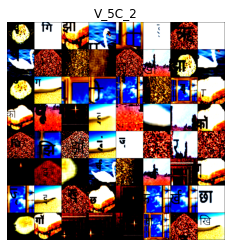

In [13]:
images, labels = next(iter(train_loader))
temp = torchvision.utils.make_grid(images)
print(temp.shape)
imshow(temp, labels)

In [0]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm_notebook

In [0]:
loss_fn_v = nn.CrossEntropyLoss()
loss_fn_c = nn.CrossEntropyLoss()



In [0]:
model_c = models.resnet18()
model_v = models.resnet18()

In [17]:
model_c.fc = nn.Linear(512,10,bias=True)
model_v.fc = nn.Linear(512,10,bias=True)

model_c.to(device)
model_v.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
opt_v = optim.Adam(model_v.parameters())
opt_c = optim.Adam(model_c.parameters())
loss_fn_v = nn.CrossEntropyLoss()
loss_fn_c =  nn.CrossEntropyLoss()

In [0]:
max_epochs = 45
loss_arr= []
st='cuda:0'


In [0]:
sample_targets , sample_labels = next(iter(train_loader))

In [21]:
print(torch.max(sample_labels[:,0,:],1))


torch.return_types.max(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
indices=tensor([5, 6, 6, 0, 4, 7, 6, 6, 9, 8, 2, 5, 0, 6, 4, 6, 0, 5, 6, 4, 4, 2, 8, 5,
        2, 2, 3, 3, 6, 2, 0, 3, 8, 0, 3, 6, 7, 6, 2, 6, 0, 5, 5, 4, 4, 4, 0, 3,
        7, 4, 8, 7, 1, 1, 2, 5, 8, 3, 9, 5, 2, 5, 8, 1]))


In [22]:
loss_arr = []


for epoch in range(max_epochs):
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    v_out = model_v(inputs)
    c_out = model_c(inputs)

    opt_v.zero_grad()
    opt_c.zero_grad()

    #v_out = vgg_v(inputs)
    #c_out = vgg_c(inputs)
        
        # targets
    vowel_targets = labels[:, 0]
    consonant_targets = labels[:, 1]
    _, vowel_targets = torch.max(vowel_targets, axis =1)
    _, consonant_targets = torch.max(consonant_targets, axis =1)
        
        
    #v_loss = loss_fn_v(v_out, vowel_targets)
    #c_loss = loss_fn_c(c_out, consonant_targets)
        
    loss = loss_fn_v(v_out, vowel_targets)  + loss_fn_c(c_out, consonant_targets) 
        
    loss.backward()
        
        # optimize the parameters
    opt_v.step( )
    opt_c.step()
    del inputs, labels
    
    loss_arr.append(loss.item())


    #if i % 100 == 0:
        #print("Iterations %d/%d loss = %0.2f"%(i, n_iters, loss.item()))
        
  print(loss.item()) 
  #print('Epoch: %d/%d , test acc : %0.2f, train Acc %0.2f'% 
   #       (epoch, max_epochs, evaluation(validation_loader, vgg_c, vgg_v), evaluation(train_loader, vgg_c, vgg_v)))

    

4.587306499481201
4.242647171020508
3.9240992069244385
3.3963449001312256
3.181135654449463
2.640371322631836
2.961015224456787
2.5583748817443848
2.0528721809387207
2.1042773723602295
2.3812668323516846
1.701728105545044
2.4465994834899902
2.100846767425537
1.8853840827941895
1.449236273765564
1.4144723415374756
2.070723056793213
1.527184247970581
1.8512842655181885
1.771956205368042
1.5442225933074951
1.5406392812728882
1.667353630065918
1.3800854682922363
1.634181261062622
1.5297819375991821
1.7302157878875732
1.3981335163116455
1.5943537950515747
1.2634356021881104
1.9112496376037598
1.8359158039093018
1.1871998310089111
1.628906011581421
1.48870849609375
1.3203401565551758
1.3284894227981567
1.4087719917297363
1.8186874389648438
1.4510188102722168
1.7214076519012451
2.054382085800171
1.8390483856201172
1.1131458282470703


In [0]:
def evaluation(dataloader, model_c, model_v):
  total,v,c= 0,0,0
    
  #total , correct_c, correct_v,correct = 0, 0,0, 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    v_out_e = model_v(inputs)
    c_out_e = model_c(inputs)

      # targets
    vowel_targets = labels[:, 0]
    consonant_targets = labels[:, 1]
    _, vowel_targets = torch.max(vowel_targets, axis =1)
    _, consonant_targets = torch.max(consonant_targets, axis =1)

    _, pred_v = torch.max(v_out_e, 1)
    _, pred_c = torch.max(c_out_e, 1)
    total += labels.size(0)
    v += (pred_v==vowel_targets).sum().item()
    c += (pred_c==consonant_targets).sum().item()

  print('total images:',total)
  print('correct vowels predictions:',v)
  print('correct consonants predictions:',c)
  print('Vowel Accuracy: ',(v/total)*100, '%')
  print('Consonants Accuracy: ',(c/total)*100,'%')
        
    
    #if( (pred_v == vowel_targets).sum().item() and  (pred_c == consonant_targets).sum().item() ):
     #   correct += 1


    #correct_v += (pred_v == vowel_targets).sum().item()

    #correct_c += (pred_c == consonant_targets).sum().item()
     #correct = correct_c + correct_v

  #return 100 * ( correct / total )








    

In [24]:
evaluation(train_loader,model_c,model_v)


total images: 9000
correct vowels predictions: 6005
correct consonants predictions: 6715
Vowel Accuracy:  66.72222222222223 %
Consonants Accuracy:  74.6111111111111 %
